# reference
- https://github.com/HabanaAI/Model-References/tree/master/TensorFlow/computer_vision/SSD_ResNet34
- https://yeomko.tistory.com/20
- https://github.com/experiencor/keras-yolo2
- step by step yolo3  https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb
- pytorch yolo3 : https://deep-learning-study.tistory.com/422
- tf yolo1: https://velog.io/@minkyu4506/YOLO-v1-리뷰-코드-구현tensorflow2

- yolo4 on keras : https://github.com/hunglc007/tensorflow-yolov4-tflite


In [143]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!unzip /content/drive/MyDrive/colab/didimdol/dataset/digit_detector.zip -d ./dataset/ > /dev/null

In [ ]:
!ln -s /content/drive/MyDrive/colab/didimdol /content/

In [41]:
from model.tensorflow.yolo.yolo import YOLO, decode, compute_loss, decode_train
from model.tensorflow.yolo.dataset import Dataset
import tensorflow as tf

import pandas as pd
import numpy as np
import time
from tqdm import tqdm

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import cv2

plt.rcParams["figure.figsize"] = (20,10)

In [34]:
import xml.etree.ElementTree as ET
import glob

def create_annotationfile(glob_path, output_path):
    files = glob.glob(glob_path)
    with open(output_path, 'w') as f:
        for filepath in tqdm(files):
            root = ET.parse(filepath)
            filename = root.find('./filename').text
            objects = root.findall('./object')

            objects_info = ""
            for o in objects:
                label = o.find('./name').text
                xmin = o.find('./bndbox/xmin').text
                ymin = o.find('./bndbox/ymin').text
                xmax = o.find('./bndbox/xmax').text
                ymax = o.find('./bndbox/ymax').text
                if label == "10" : label = '0'
                objects_info += ' {},{},{},{},{}'.format(xmin, ymin, xmax, ymax, label)
            row = 'dataset/server_room/train/'+filename+objects_info + '\n'
            f.write(row)

create_annotationfile('dataset/server_room/annotation/*.xml', 'dataset/server_room/train_digit.txt')

100%|██████████| 1298/1298 [00:00<00:00, 2698.75it/s]


# anontaion 파일 로드
- 파일명 x1,y1,x2,y2,label x1,y1,x2,y2,label

In [36]:
data_info = []
with open('dataset/server_room/train_digit.txt') as f:
    preview = 0
    for row in f.readlines():
        if preview < 5:
            preview += 1

        cols = row.split()
        for idx, value in enumerate(cols):
            if idx == 0:
                filepath = value
            else:
                label,x,y,w,h = value.split(',')
                data_info.append([filepath, label,x,y,w,h])

pd_dataset = pd.DataFrame(data_info, columns=['filepath', 'x1', 'y1','x2', 'y2', 'label'])
pd_dataset.head()

,filepath,x1,y1,x2,y2,label
0,dataset/server_room/train/1131_image_4.jpg,411,607,426,632,0
1,dataset/server_room/train/1131_image_4.jpg,452,601,463,619,0
2,dataset/server_room/train/1131_image_4.jpg,374,607,382,632,1
3,dataset/server_room/train/1131_image_4.jpg,386,607,396,632,1
4,dataset/server_room/train/1131_image_4.jpg,440,601,453,619,2


# 학습 데이터 샘플

In [37]:
with open('dataset/digit_detector/train_digit.txt') as f:
    print('학습데이터 개수', len(f.readlines()))

학습데이터 개수 33402


In [6]:
with open('dataset/digit_detector/test_digit.txt') as f:
    print('테스트데이터 개수', len(f.readlines()))

테스트데이터 개수 13068


In [8]:
import cv2
import matplotlib.pyplot as plt
import random

In [11]:
random.randrange()

0.13699460950667275

In [ ]:
# 

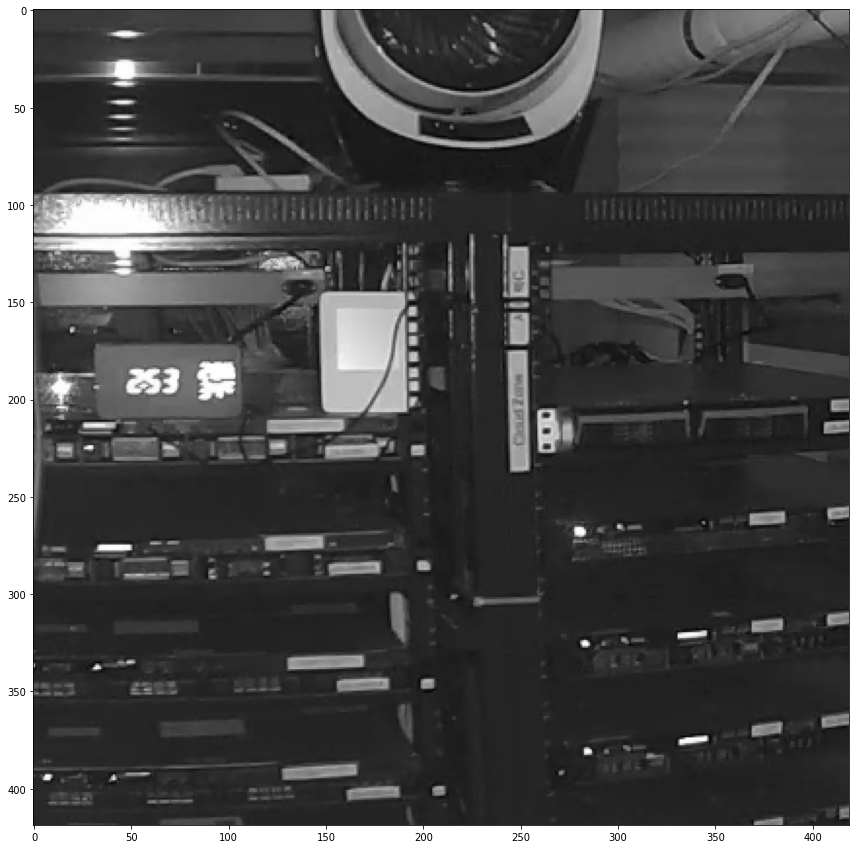

In [14]:
p  = '/Users/handh/dev/workspace/python/didimdol_ai_model/dataset/server_room/train/0254_image_4.jpg'
img = cv2.imread(p)
img = img[300:1000,300:1000,:]
img = cv2.resize(img, (419,419))

plt.figure(figsize=(30,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

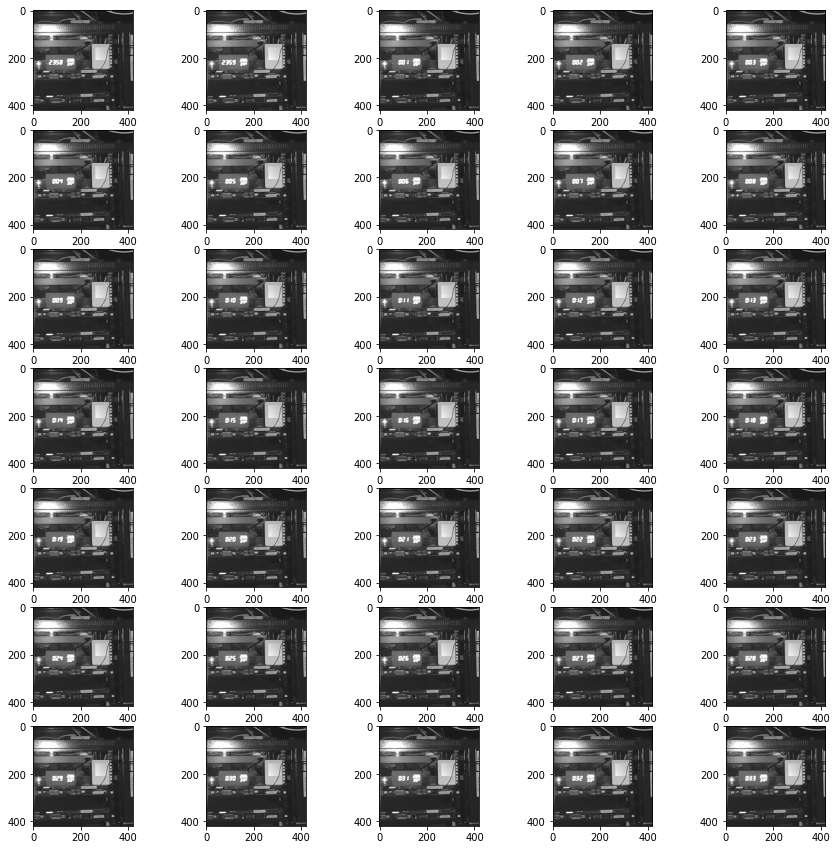

In [44]:
fig = plt.figure(figsize=(15, 15))
rows = 7
cols = 5

groups = pd_dataset.groupby('filepath').size()
files = groups.keys()
for idx in range(0, rows*cols):
    img = cv2.imread(files[idx])
    img = img[400:819,300:719,:]
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

# 학습 데이터의 클래스 정보

In [8]:
pd_dataset.label.value_counts()

1    13861
2    10585
3     8497
4     7458
5     6882
6     5727
7     5595
8     5045
0     4948
9     4659
Name: label, dtype: int64

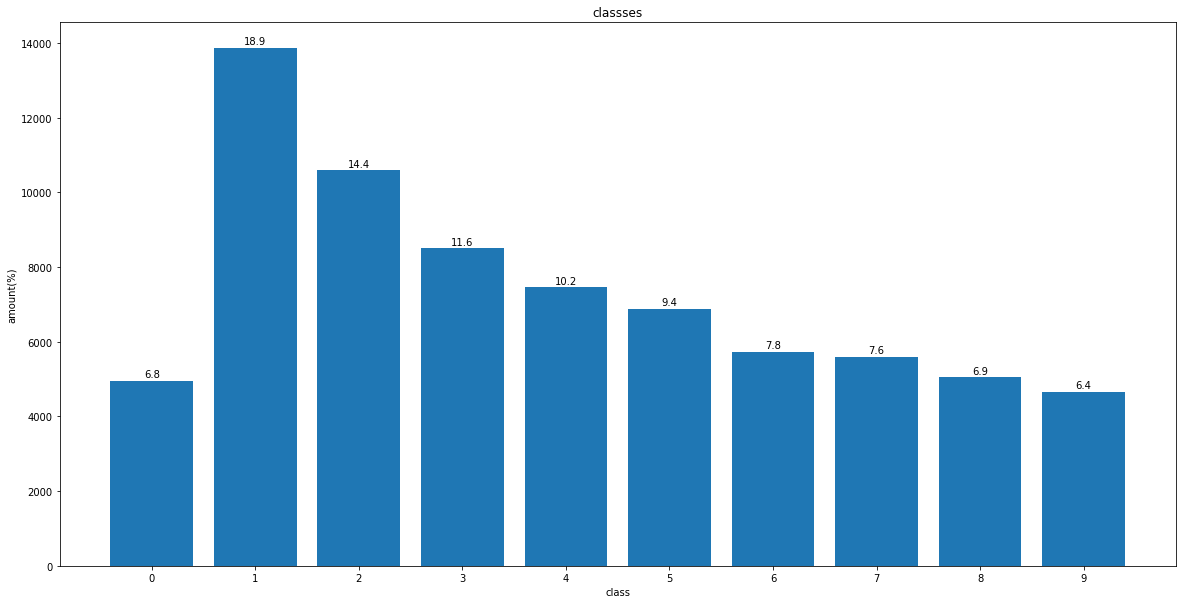

In [243]:
classes_info = pd_dataset.label.value_counts().sort_index(key=lambda x: x.astype(int))
plt.bar(classes_info.index.values, classes_info.values)

total_count = sum(classes_info.values)

for idx, value in enumerate(classes_info.index.values):
    plt.text(idx, classes_info.values[idx]+ 100, '{:.1f}'.format(classes_info.values[idx] / total_count * 100) , ha='center')

plt.title('classses')
plt.xlabel('class')
plt.ylabel('amount(%)')
plt.show()

# 이미지 크기 정보

In [10]:
image_shapes= []
for path in tqdm(pd_dataset.filepath):
    img_h, img_w, _ = cv2.imread(path).shape
    image_shapes.append([img_w, img_h])

100%|██████████| 73257/73257 [00:35<00:00, 2086.32it/s]


In [11]:
image_info = []

for idx, (img_w, img_h) in tqdm(enumerate(image_shapes)):
    object_w = int(pd_dataset.iloc[idx]['x2']) - int(pd_dataset.iloc[idx]['x1'])
    object_h = int(pd_dataset.iloc[idx]['y2']) - int(pd_dataset.iloc[idx]['y1'])
    
    image_info.append([img_w, img_h, object_w, object_h, object_w/img_w, object_h/img_h])

image_info = np.array(image_info)

73257it [00:12, 5728.37it/s]


이미지 평균 크기 w,h

In [12]:
image_info.mean(axis=0)[:2]

array([133.6496717,  58.3324597])

이미지 최대 크기 w,h

In [13]:
image_info.max(axis=0)[:2]

array([876., 501.])

이미지 최소 크기 w,h

In [14]:
image_info.min(axis=0)[:2]

array([25., 12.])

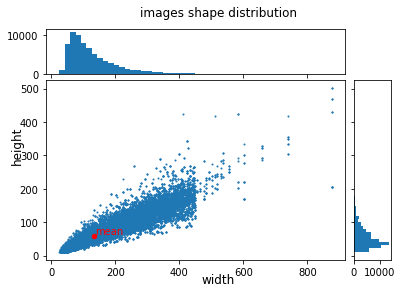

In [15]:
def scatter_hist(x, y, fig):
    gs = fig.add_gridspec(2, 2,  
                      width_ratios=(8, 1), height_ratios=(2, 8),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0])
    ax_histy = fig.add_subplot(gs[1, 1]) # , sharey=ax)

    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s=1)
    ax.scatter([x.mean()] , [y.mean()], s=20, c='red')
    ax.text(x.mean()+5, y.mean()+5, 'mean', c='red')

    binwidth = 50
    ax_histx.hist(x, bins=binwidth)
    ax_histy.hist(y, bins=binwidth, orientation='horizontal')
    
fig = plt.figure()
scatter_hist(image_info[:,0], image_info[:,1], fig)
fig.supxlabel('width')
fig.supylabel('height')
fig.suptitle('images shape distribution')
plt.show()

# 오브젝트 정보

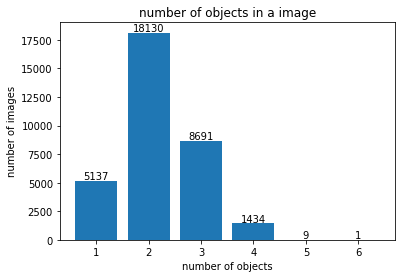

In [16]:
length = pd_dataset.groupby('filepath').size().max()

ys, xs, patches = plt.hist(pd_dataset.groupby('filepath').size(), bins=length, rwidth=0.8)

xs = [(xs[i] + xs[i+1])/2 for i in range(0, len(xs)-1)]

for idx in range(length):
    plt.text(xs[idx], ys[idx] + 150, int(ys[idx]), ha='center')

plt.xticks(xs, range(1, length+1))
plt.title('number of objects in a image')
plt.xlabel('number of objects')
plt.ylabel('number of images')
plt.show()

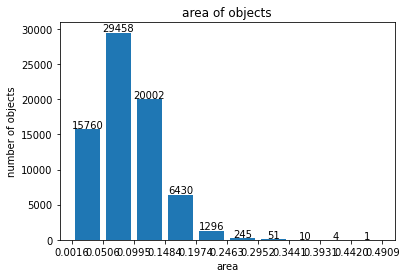

In [17]:
bins = 10
areas = image_info[:,4] * image_info[:,5]
ys, xs, patches = plt.hist(areas, bins=bins, rwidth=0.8)

xs_t = [(xs[i] + xs[i+1])/2 for i in range(0, len(xs)-1)]

for idx in range(bins):
    plt.text(xs_t[idx], ys[idx] + 150, int(ys[idx]), ha='center')

plt.xticks(xs)
plt.title('area of objects')
plt.xlabel('area')
plt.ylabel('number of objects')
plt.show()

In [18]:
print('오브젝트 평균 크기(w,h, w(%),h(%))', image_info.mean(axis=0)[2:])
print('최대크기', image_info.max(axis=0)[2:])
print('최소크기', image_info.min(axis=0)[2:])

오브젝트 평균 크기(w,h, w(%),h(%)) [16.65049074 33.86131018  0.13375698  0.63574466]
최대크기 [207.         403.           0.51937984   1.30769231]
최소크기 [1.         9.         0.01052632 0.09411765]


4948it [00:03, 1316.76it/s]
13861it [00:10, 1362.75it/s]
10585it [00:07, 1376.36it/s]
8497it [00:06, 1351.11it/s]
7458it [00:05, 1348.35it/s]
6882it [00:05, 1357.88it/s]
5727it [00:04, 1289.03it/s]
5595it [00:04, 1360.09it/s]
5045it [00:03, 1335.57it/s]
4659it [00:03, 1348.29it/s]


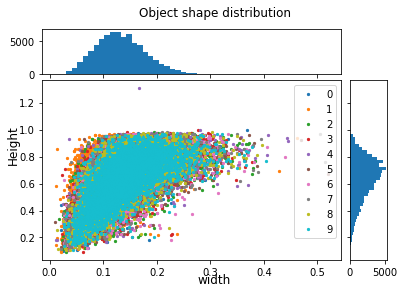

In [19]:
groups = pd_dataset.groupby('label')

fig = plt.figure()

gs = fig.add_gridspec(2, 2,  
                      width_ratios=(8, 1), height_ratios=(2, 8),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

binwidth = 50
ax_histx.hist(image_info[:,4], bins=binwidth)
ax_histy.hist(image_info[:,5], bins=binwidth, orientation='horizontal')

for name, group in groups:
    info = []
    for idx, path in tqdm(enumerate(group.filepath)):
        img_h, img_w, _ = cv2.imread(path).shape
        object_w = int(group.iloc[idx]['x2']) - int(group.iloc[idx]['x1'])
        object_h = int(group.iloc[idx]['y2']) - int(group.iloc[idx]['y1'])

        info.append([object_w/img_w, object_h/img_h])

    info = np.array(info)
    ax.scatter(info[:,0], info[:,1], s=5, label=name)

ax.legend()
# ax.scatter([image_info[:,4].mean()] , [image_info[:,5].mean()], s=20, c='red')
# ax.text(x.mean()+5, y.mean()+5, 'mean', c='red')

fig.suptitle('Object shape distribution')
fig.supxlabel('width')
fig.supylabel('Height')

plt.show()

100%|██████████| 73257/73257 [00:08<00:00, 8730.39it/s]
C:\Users\Han\AppData\Local\Temp\ipykernel_30336\1478932035.py:13: RuntimeWarning: divide by zero encountered in log
  mat = np.nan_to_num(np.log(mat), neginf=0)


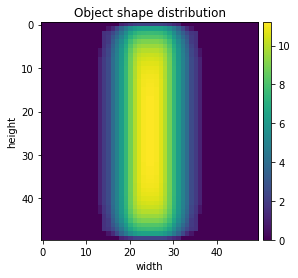

In [20]:
MAT_SIZE = 50
CENTER = int(MAT_SIZE/2)
mat = np.zeros([MAT_SIZE,MAT_SIZE]) # center 49
for image in tqdm(image_info):
    w, h = image[4], image[5]
    half_w = int((MAT_SIZE * w) / 2)
    half_h = int((MAT_SIZE * h) / 2 + 0.5)

    for i in range( CENTER - half_h, min(CENTER + half_h, MAT_SIZE)):
        for j in range( CENTER - half_w, min(CENTER + half_w, MAT_SIZE)):
            mat[i][j] += 1

mat = np.nan_to_num(np.log(mat), neginf=0)

fig = plt.figure()
ax = plt.axes()
im = ax.matshow(mat)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
ax.set_title('Object shape distribution')
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.xaxis.tick_bottom()

plt.show()

73257it [00:12, 5652.93it/s]
C:\Users\Han\AppData\Local\Temp\ipykernel_30336\1135412441.py:12: RuntimeWarning: divide by zero encountered in log
  mat = np.nan_to_num(np.log(mat), neginf=0)


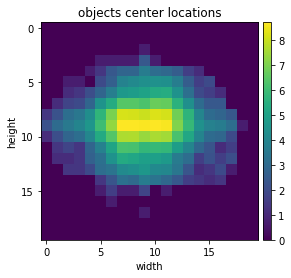

In [21]:
MAT_SIZE = 20
mat = np.zeros([MAT_SIZE,MAT_SIZE]) # center 49

for idx, (img_w, img_h) in tqdm(enumerate(image_shapes)):
    x = (int(pd_dataset.iloc[idx]['x2']) + int(pd_dataset.iloc[idx]['x1'])) /2 
    y = (int(pd_dataset.iloc[idx]['y2']) + int(pd_dataset.iloc[idx]['y1'])) /2
    idx_x = int(min(x / img_w * (MAT_SIZE-1), MAT_SIZE-1))
    idx_y = int(min(y / img_h * (MAT_SIZE-1), MAT_SIZE-1))
    mat[idx_y][idx_x] += 1    


mat = np.nan_to_num(np.log(mat), neginf=0)

fig = plt.figure()
ax = plt.axes()
im = ax.matshow(mat)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
ax.set_title('objects center locations')
ax.set_xlabel('width')
ax.set_ylabel('height')
ax.xaxis.tick_bottom()


plt.show()

# 모델 학습 기본 셋업

In [2]:
INPUT_SIZE = 416
NUM_CLASS = 10
EPOCHS = 500
BATCH_SIZE = 8
IOU_LOSS_THRESH = 0.5

CLASSES = ['0','1','2','3','4','5','6','7','8','9']

# __C.YOLO.CLASSES              = ["car"]
# ANCHORS              = [12,16, 19,36, 40,28, 36,75, 76,55, 72,146, 142,110, 192,243, 459,401]
# __C.YOLO.ANCHORS_V3           = [10,13, 16,30, 33,23, 30,61, 62,45, 59,119, 116,90, 156,198, 373,326]
ANCHORS        = [23,27, 37,58, 81,82, 81,82, 135,169, 344,319]
# __C.YOLO.STRIDES              = [8, 16, 32]
# STRIDES       =  [8, 16, 32]
STRIDES       =  [16, 32]
# XYSCALE              = [1.2, 1.1, 1.05]
XYSCALE       = [1.05, 1.05]
ANCHOR_PER_SCALE     = 3
# __C.YOLO.IOU_LOSS_THRESH      = 0.5

# 모델 구조 생성

In [29]:
input_layer = tf.keras.layers.Input([INPUT_SIZE, INPUT_SIZE, 3])

feature_maps = YOLO(input_layer, NUM_CLASS, is_tiny = True)
bbox_tensors = []
for i, fm in enumerate(feature_maps):
    if i == 0:
        bbox_tensor = decode_train(fm, INPUT_SIZE // 16, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    elif i == 1:
        bbox_tensor = decode_train(fm, INPUT_SIZE // 32, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
    # else:
    #     bbox_tensor = decode_train(fm, INPUT_SIZE // 32, NUM_CLASS, STRIDES, ANCHORS, i, XYSCALE)
        
    bbox_tensors.append(fm)
    bbox_tensors.append(bbox_tensor)

model = tf.keras.Model(input_layer, bbox_tensors)

TYNY!


# 학습 데이터 로드

In [126]:
annot_path = 'dataset/digit_detector/train_digit.txt'
trainset = Dataset(annot_path, INPUT_SIZE, BATCH_SIZE,  CLASSES, ANCHORS, ANCHOR_PER_SCALE, STRIDES, data_aug=True, is_training=True)
len(trainset)

4176

# 학습 시작

In [127]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [115]:
for epoch in range(EPOCHS):
    total_loss = 0.
    total_giou_loss = 0.
    total_conf_loss = 0.
    total_prob_loss = 0.

    start_time = time.time()

    progress = tqdm(trainset)
    for image_data, target in progress:
        with tf.GradientTape() as tape:
            pred_result = model(image_data, training=True)
            giou_loss = conf_loss = prob_loss = 0
            
            # optimizing process
            for i in range(2):
                conv, pred = pred_result[i * 2], pred_result[i * 2 + 1]
                loss_items = compute_loss(pred, conv, target[i][0], target[i][1], STRIDES=STRIDES, NUM_CLASS=NUM_CLASS, IOU_LOSS_THRESH=IOU_LOSS_THRESH, i=i)
                giou_loss += loss_items[0]
                conf_loss += loss_items[1]
                prob_loss += loss_items[2]

            step_loss = giou_loss + conf_loss + prob_loss

            gradients = tape.gradient(step_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            total_loss += step_loss

            total_giou_loss += giou_loss
            total_conf_loss += conf_loss
            total_prob_loss += prob_loss

            progress.set_postfix({'loss' : step_loss.numpy()})
        
    total_loss = total_loss / len(trainset)
    total_conf_loss = total_conf_loss / len(trainset)
    total_giou_loss = total_giou_loss / len(trainset)
    total_prob_loss = total_prob_loss / len(trainset)

    print('trn {:d}: elapsed {:.2f}s, iou loss {:.4f}, conf loss {:.4f}, prob loss {:.4f}, total loss {:.4f}'.format(
            epoch, 
            time.time()- start_time, 
            total_giou_loss.numpy(), 
            total_conf_loss.numpy(), 
            total_prob_loss.numpy(), 
            total_loss.numpy()))


    model.save_weights("./didimdol/checkpoints/yolov4")

    # start_time = time.time()
    # for image_data, target in trainset:
    #     with tf.GradientTape() as tape:
    #         pred_result = model(image_data, training=True)
    #         giou_loss = conf_loss = prob_loss = 0

    #         # optimizing process
    #         for i in range(3):
    #             conv, pred = pred_result[i * 2], pred_result[i * 2 + 1]
    #             loss_items = compute_loss(pred, conv, target[i][0], target[i][1], STRIDES=STRIDES, NUM_CLASS=NUM_CLASS, IOU_LOSS_THRESH=IOU_LOSS_THRESH, i=i)
    #             giou_loss += loss_items[0]
    #             conf_loss += loss_items[1]
    #             prob_loss += loss_items[2]

    #         total_loss = giou_loss + conf_loss + prob_loss

    # total_loss = total_loss / len(trainset)
    # print('val {}: elapsed {:.2f}s, total loss {:.4f}'.format(epoch, time.time()- start_time, total_loss.numpy()))




NameError: name 'trainset' is not defined

In [ ]:
from tensorflow.python.saved_model import tag_constants
import cv2
from matplotlib import pyplot as plt

In [18]:
# infer_model.load_weights( './didimdol/checkpoints/yolov4')
infer_model = tf.keras.models.load_model('./checkpoints/yolov4')

In [9]:
palette = [(255, 56, 56),
    (255, 157, 151),
    (255, 112, 31),
    (255, 178, 29),
    (207, 210, 49),
    (72, 249, 10),
    (146, 204, 23),
    (61, 219, 134),
    (26, 147, 52),
    (0, 212, 187),
    (44, 153, 168),
    (0, 194, 255),
    (52, 69, 147),
    (100, 115, 255),
    (0, 24, 236),
    (132, 56, 255),
    (82, 0, 133),
    (203, 56, 255),
    (255, 149, 200),
    (255, 55, 199)]

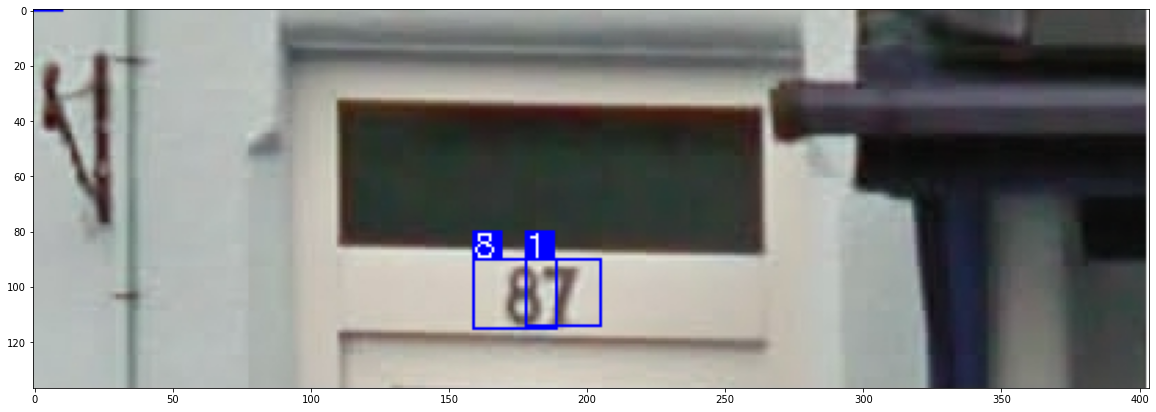

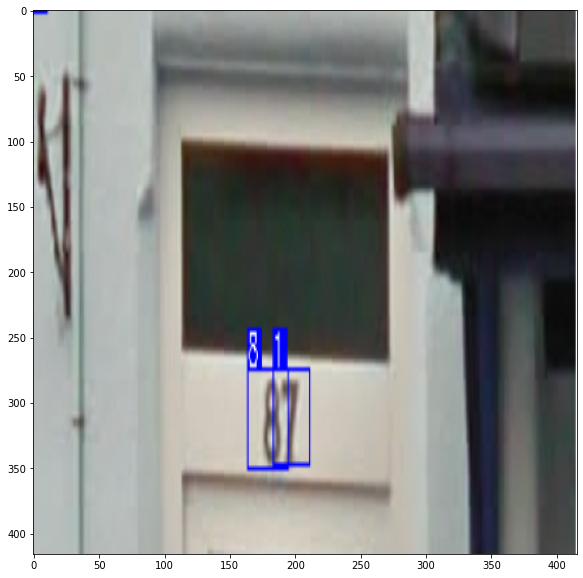

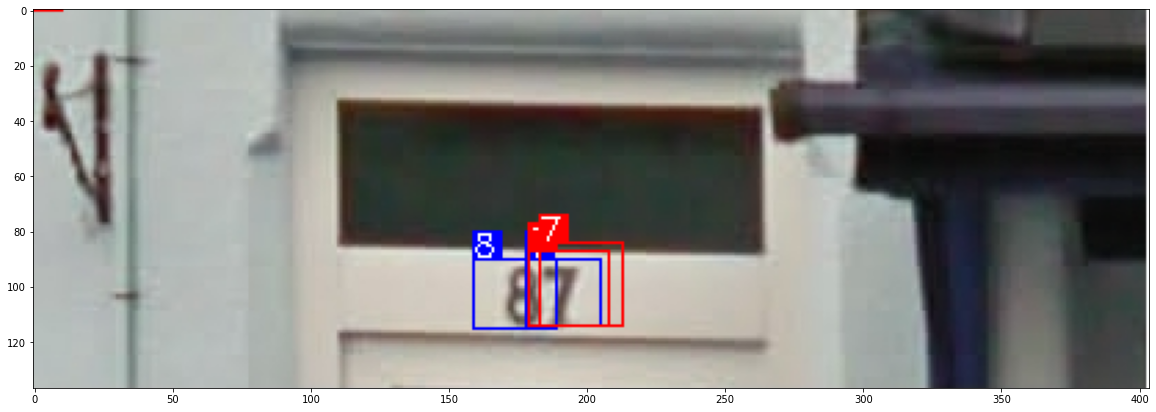

tf.Tensor([[178.26944  303.19168   26.735445  81.139946]], shape=(1, 4), dtype=float32) tf.Tensor(0.29226622, shape=(), dtype=float32) 8
tf.Tensor([[197.83208  303.64685   28.842829  82.72424 ]], shape=(1, 4), dtype=float32) tf.Tensor(0.37484244, shape=(), dtype=float32) 7
tf.Tensor([[175.56145  314.63318   26.175138  82.18209 ]], shape=(1, 4), dtype=float32) tf.Tensor(0.5996285, shape=(), dtype=float32) 8
tf.Tensor([[179.59238 313.0165   30.47849  75.16039]], shape=(1, 4), dtype=float32) tf.Tensor(0.87560153, shape=(), dtype=float32) 8
tf.Tensor([[197.79897  309.83438   28.527466  73.07968 ]], shape=(1, 4), dtype=float32) tf.Tensor(0.95415014, shape=(), dtype=float32) 1


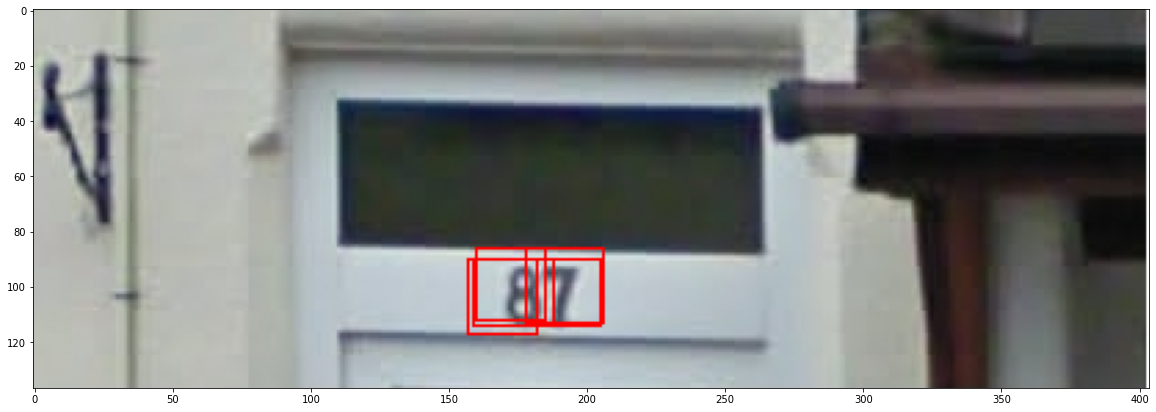

In [41]:
original_image = cv2.imread('dataset/digit_detector/test/155.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# image = image[100:400, 100:500]

plt.imshow(image)
plt.show()

image_data = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE))

plt.imshow(image_data)
plt.show()

image_data = image_data / 255.

images_data = []
pred_bbox = []
for i in range(1):
    images_data.append(image_data)
images_data = np.asarray(images_data).astype(np.float32)
batch_data = tf.constant(images_data)
preds = infer_model(batch_data, training=False)

box_list = []
conf_list = []
for idx, output in enumerate(preds):
    if idx % 2 == 0 : continue
    boxes = output[:, :, :, :,  0:4]
    pred_conf = output[:, :, :, :, 4:]

    bs, xi, yi, anc, xywh = boxes.shape
    box_list.append(tf.reshape(boxes, (bs, -1, 1, xywh)))
    bs, xi, yi, anc, conf = pred_conf.shape
    conf_list.append(tf.reshape(pred_conf, (bs, -1, conf)))

boxes = tf.concat([box_list[0], box_list[1]], 1).numpy()
pred_conf =  tf.concat([conf_list[0], conf_list[1]], 1).numpy()

classes_prob =  pred_conf[:, :, 1:] * pred_conf[:, :, :1]

boxes[:,:,:,0] = boxes[:,:,:,0] - (boxes[:,:,:, 2] / 2) # x1
boxes[:,:,:,1] = boxes[:,:,:,1] - (boxes[:,:,:, 3] / 2) # y1

boxes[:,:,:,2] = boxes[:,:,:,0] + boxes[:,:,:, 2] # x2
boxes[:,:,:,3] = boxes[:,:,:,1] + boxes[:,:,:, 3] # y2

o_boxes, scores, classes, detections = tf.image.combined_non_max_suppression(
    boxes=boxes,
    scores=classes_prob,
    max_output_size_per_class= 20,
    max_total_size=30,
    iou_threshold=0.4,
    score_threshold=0.3,
    clip_boxes = False
)

o_h, o_w, _ = image.shape
for idx, box in enumerate(o_boxes[0]):
    box = box / INPUT_SIZE
    x1 = int(o_w * box[0])
    y1 = int(o_h * box[1])
    x2 = int(o_w * box[2])
    y2 = int(o_h * box[3])

    cv2.rectangle(image, (x1, y1), (x2,y2), (255,0,0), 1)
    cv2.rectangle(image, (x1, y1-10), (x1+10,y1), (255,0,0), -1)
    cv2.putText(image, '{}'.format(int(classes[0][idx])), (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
    
plt.imshow(image)
plt.show()
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

image_data = cv2.resize(original_image, (INPUT_SIZE, INPUT_SIZE))
image_data = image_data / 255.

images_data = []
pred_bbox = []
for i in range(1):
    images_data.append(image_data)
images_data = np.asarray(images_data).astype(np.float32)
batch_data = tf.constant(images_data)
preds = infer_model(batch_data, training=False)

box_list = []
conf_list = []
for idx, output in enumerate(preds):
    if idx % 2 == 0 : continue
    boxes = output[:, :, :, :,  0:4]
    pred_conf = output[:, :, :, :, 4:]
    box_list.append(tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)))
    conf_list.append(tf.reshape(pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])))

boxes = tf.concat([box_list[0], box_list[1]], 1)
pred_conf =  tf.concat([conf_list[0], conf_list[1]], 1)

o_h, o_w, _ = original_image.shape

mask = pred_conf[:,:,0] >= 0.25
mask = tf.reshape(mask, mask.shape[1])

for idx, box in enumerate(boxes[0]):
    # if mask[idx]:
    if mask[idx]:
        print(box, pred_conf[0,idx,0], np.argmax(pred_conf[0,idx,1:]))
        box = box[0] / INPUT_SIZE

        w = o_w * box[2]
        h = o_h * box[3]

        x1 = int(o_w * box[0] - (w/2))
        y1 = int(o_h * box[1] - (h/2))
        x2 = int(x1 + w)
        y2 = int(y1 + h)

        # print(box, x1, y1, x2, y2)
        cv2.rectangle(original_image, (x1, y1), (x2,y2), (255,0,0), 1)

plt.imshow(original_image)
plt.show()

In [ ]:
!rm -rf ./didimdol/eval
!mkdir ./didimdol/eval

In [144]:
import glob
import os 
from tqdm import tqdm


OUTPUT_DIR = './didimdol/eval'

def inference(model, image_dir, output_dir = OUTPUT_DIR):
    paths = glob.glob(image_dir, recursive=True)
    for img_path in tqdm(paths):
        original_image = cv2.imread(img_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        o_h, o_w, _ = original_image.shape

        image_data = cv2.resize(original_image, (INPUT_SIZE, INPUT_SIZE))
        image_data = image_data / 255.

        images_data = []
        pred_bbox = []
        for i in range(1):
            images_data.append(image_data)
        images_data = np.asarray(images_data).astype(np.float32)
        batch_data = tf.constant(images_data)
        preds = infer_model(batch_data, training=False)

        box_list = []
        conf_list = []
        for idx, output in enumerate(preds):
            if idx % 2 == 0 : continue
            boxes = output[:, :, :, :,  0:4]
            pred_conf = output[:, :, :, :, 4:]
            box_list.append(tf.reshape(boxes, (-1, 4)))
            conf_list.append(tf.reshape(pred_conf, (-1, tf.shape(pred_conf)[-1])))

        boxes = tf.concat([box_list[0], box_list[1], box_list[2]], 0)
        pred_conf =  tf.concat([conf_list[0], conf_list[1], conf_list[2]], 0)
        classes_prob = pred_conf[:,0] # *  pred_conf[:,:,1]
        box_num = tf.shape(classes_prob)
        # classes_prob = tf.reshape(classes_prob, (batch_size, box_num, 1))

        x1 = boxes[:, 0] - (boxes[:, 2] / 2)
        y1 = boxes[:, 1] - (boxes[:, 3] / 2)
        x2 = x1 + boxes[:, 2]
        y2 = y1 + boxes[:, 3]
        boxes = tf.concat([tf.reshape(x1, (x1.shape[-1], 1)), tf.reshape(y1, (y1.shape[-1], 1)), tf.reshape(x2, (x2.shape[-1], 1)), tf.reshape(y2, (y2.shape[-1], 1))], 1)
        o_boxes = tf.image.non_max_suppression(
            boxes=boxes,
            scores=classes_prob,
            max_output_size=10,
            iou_threshold=0.5,
            score_threshold=0.27
        )

        for idx in o_boxes:
            box = boxes[idx]
            box = box / INPUT_SIZE
            x1 = int(o_w * box[0])
            y1 = int(o_h * box[1])
            x2 = int(o_w * box[2])
            y2 = int(o_h * box[3])
            cv2.rectangle(original_image, (x1, y1), (x2,y2), (255,0,0), 3)

        cv2.imwrite(os.path.join(OUTPUT_DIR, os.path.basename(img_path)), original_image)


In [145]:
img_dir = '/content/dataset/car_object_detection/testing_images/*.jpg'
inference(infer_model, img_dir)

0it [00:00, ?it/s]


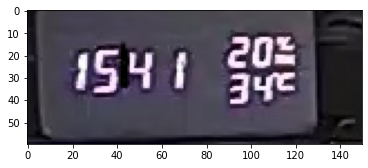

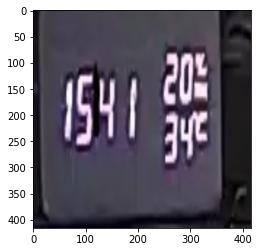

5:0.92 tf.Tensor([0.187311   0.27319103 0.28974575 0.63360554], shape=(4,), dtype=float32)
2:0.88 tf.Tensor([0.57677245 0.14982632 0.67187876 0.44075027], shape=(4,), dtype=float32)
0:0.86 tf.Tensor([0.6625319  0.16051504 0.74912584 0.44251406], shape=(4,), dtype=float32)
1:0.77 tf.Tensor([0.12638642 0.27676016 0.19119772 0.63007104], shape=(4,), dtype=float32)
4:0.72 tf.Tensor([0.28473717 0.26632178 0.38835573 0.6265551 ], shape=(4,), dtype=float32)
4:0.71 tf.Tensor([0.65786684 0.43764147 0.7541888  0.70088094], shape=(4,), dtype=float32)
3:0.52 tf.Tensor([0.5645428  0.46408823 0.6775498  0.7741959 ], shape=(4,), dtype=float32)
7:0.45 tf.Tensor([0.56908363 0.45097506 0.6730337  0.74041086], shape=(4,), dtype=float32)
8:0.25 tf.Tensor([0.7251918  0.39586133 0.8204085  0.6520229 ], shape=(4,), dtype=float32)
2:0.25 tf.Tensor([0.5547564  0.45677483 0.67082626 0.7436314 ], shape=(4,), dtype=float32)
3:0.21 tf.Tensor([0.7206474  0.41235608 0.82689726 0.69507396], shape=(4,), dtype=float32)

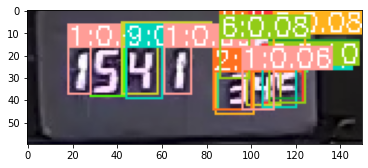

In [33]:
image = cv2.imread("dataset/digit_detector/eval/4.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = image[50:, :150, :]

plt.imshow(image)
plt.show()

# image_data = cv2.resize(image, (int(INPUT_SIZE/3), int(INPUT_SIZE/3)))
image_data = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE))

plt.imshow(image_data)
plt.show()

image_data = image_data / 255.

images_data = []
pred_bbox = []
for i in range(1):
    images_data.append(image_data)
images_data = np.asarray(images_data).astype(np.float32)
batch_data = tf.constant(images_data)
preds = infer_model(batch_data, training=False)

box_list = []
conf_list = []
for idx, output in enumerate(preds):
    if idx % 2 == 0 : continue
    boxes = output[:, :, :, :,  0:4]
    pred_conf = output[:, :, :, :, 4:]

    bs, xi, yi, anc, xywh = boxes.shape
    box_list.append(tf.reshape(boxes, (bs, -1, 1, xywh)))
    bs, xi, yi, anc, conf = pred_conf.shape
    conf_list.append(tf.reshape(pred_conf, (bs, -1, conf)))

boxes = tf.concat([box_list[0], box_list[1]], 1).numpy()
pred_conf =  tf.concat([conf_list[0], conf_list[1]], 1).numpy()

classes_prob =  pred_conf[:, :, 1:] * pred_conf[:, :, :1]

boxes[:,:,:,0] = boxes[:,:,:,0] - (boxes[:,:,:, 2] / 2) # x1
boxes[:,:,:,1] = boxes[:,:,:,1] - (boxes[:,:,:, 3] / 2) # y1

boxes[:,:,:,2] = boxes[:,:,:,0] + boxes[:,:,:, 2] # x2
boxes[:,:,:,3] = boxes[:,:,:,1] + boxes[:,:,:, 3] # y2

o_boxes, scores, classes, detections = tf.image.combined_non_max_suppression(
    boxes=boxes,
    scores=classes_prob,
    max_output_size_per_class= 20,
    max_total_size=30,
    iou_threshold=0.4,
    score_threshold=0.05,
    clip_boxes = False
)

o_h, o_w, _ = image.shape
for idx, box in enumerate(o_boxes[0][:detections[0]]):
    box = box / INPUT_SIZE
    x1 = int(o_w * box[0])
    y1 = int(o_h * box[1])
    x2 = int(o_w * box[2])
    y2 = int(o_h * box[3])

    class_idx = int(classes[0][idx])
    color = palette[class_idx]
    # score = int(scores[0][idx] * 100)

    cv2.rectangle(image, (x1, y1), (x2,y2), color, 1)
    cv2.rectangle(image, (x1, y1-10), (x1+40,y1), color, -1)
   
    cv2.putText(image, '{}:{:.2f}'.format(class_idx, scores[0][idx]), (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
    print('{}:{:.2f}'.format(class_idx, scores[0][idx]), box)
    
plt.imshow(image)
plt.show()

In [26]:
classes

<tf.Tensor: shape=(1, 30), dtype=float32, numpy=
array([[6., 3., 5., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [81]:
pred_conf.shape
# classes_prob.shape

(1, 2535, 11)

In [12]:
image = cv2.imread("dataset/1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

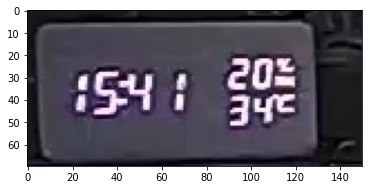

In [16]:
plt.imshow(image[40:, 0:150])
plt.show()

In [45]:
scores

<tf.Tensor: shape=(1, 30), dtype=float32, numpy=
array([[0.7175909, 0.5483335, 0.2934924, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ]],
      dtype=float32)>

In [7]:
def inf(image_path, batch_data):
    # image = cv2.imread("dataset/digit_detector/eval/4.png")
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image_data = cv2.resize(image_data, (INPUT_SIZE, INPUT_SIZE))
    # image_data = image_data / 255.

    # images_data = []
    # pred_bbox = []
    # for i in range(1):
    #     images_data.append(image_data)
    # images_data = np.asarray(images_data).astype(np.float32)
    # batch_data = tf.constant(images_data)
    preds = infer_model(batch_data, training=False)

    box_list = []
    conf_list = []
    for idx, output in enumerate(preds):
        if idx % 2 == 0 : continue
        boxes = output[:, :, :, :,  0:4]
        pred_conf = output[:, :, :, :, 4:]

        bs, xi, yi, anc, xywh = boxes.shape
        box_list.append(tf.reshape(boxes, (bs, -1, 1, xywh)))
        bs, xi, yi, anc, conf = pred_conf.shape
        conf_list.append(tf.reshape(pred_conf, (bs, -1, conf)))

    boxes = tf.concat([box_list[0], box_list[1]], 1).numpy()
    pred_conf =  tf.concat([conf_list[0], conf_list[1]], 1).numpy()

    classes_prob =  pred_conf[:, :, 1:] * pred_conf[:, :, :1]

    boxes[:,:,:,0] = boxes[:,:,:,0] - (boxes[:,:,:, 2] / 2) # x1
    boxes[:,:,:,1] = boxes[:,:,:,1] - (boxes[:,:,:, 3] / 2) # y1

    boxes[:,:,:,2] = boxes[:,:,:,0] + boxes[:,:,:, 2] # x2
    boxes[:,:,:,3] = boxes[:,:,:,1] + boxes[:,:,:, 3] # y2

    o_boxes, scores, classes, detections = tf.image.combined_non_max_suppression(
        boxes=boxes,
        scores=classes_prob,
        max_output_size_per_class= 20,
        max_total_size=30,
        iou_threshold=0.4,
        score_threshold=0.1,
        clip_boxes = False
    )

    # path = testset.annotations[idx, 0]
    image = cv2.imread(image_path)
    plt.imshow(image)
    plt.show()
    o_h, o_w, _ = image.shape
    for idx, box in enumerate(o_boxes[0][:detections[0]]):
        box = box / INPUT_SIZE
        x1 = int(o_w * box[0])
        y1 = int(o_h * box[1])
        x2 = int(o_w * box[2])
        y2 = int(o_h * box[3])

        class_idx = int(classes[0][idx])
        color = palette[class_idx]
        # score = int(scores[0][idx] * 100)

        cv2.rectangle(image, (x1, y1), (x2,y2), color, 1)
        cv2.rectangle(image, (x1, y1-10), (x1+40,y1), color, -1)
    
        cv2.putText(image, '{}:{:.2f}'.format(class_idx, scores[0][idx]), (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
        print('{}:{:.2f}'.format(class_idx, scores[0][idx]), box)
        
    plt.imshow(image)
    plt.show()


In [4]:
import model.tensorflow.yolo.utils as utils


In [15]:
annot_path = 'dataset/digit_detector/test_digit.txt'
testset = Dataset(annot_path, INPUT_SIZE, 1,  CLASSES, ANCHORS, ANCHOR_PER_SCALE, STRIDES, data_aug=False, is_training=False)
len(testset)

13068

0it [00:00, ?it/s]

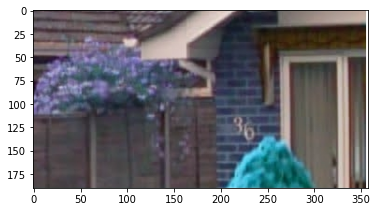

2:0.98 tf.Tensor([0.38760507 0.38084808 0.49097922 0.59226507], shape=(4,), dtype=float32)
2:0.57 tf.Tensor([0.50128925 0.38567212 0.600486   0.59890604], shape=(4,), dtype=float32)
7:0.25 tf.Tensor([0.49019724 0.34678608 0.60331446 0.5749769 ], shape=(4,), dtype=float32)
3:0.10 tf.Tensor([0.50128925 0.38567212 0.600486   0.59890604], shape=(4,), dtype=float32)


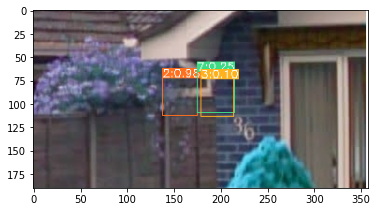

0it [00:00, ?it/s]


In [17]:
for idx, (images, target) in tqdm(enumerate(testset)):
    image_path = testset.annotations[0].split()[0]
    inf(image_path, images)
    break

In [111]:
testset.annotations[0].split()[0]

'dataset/digit_detector/train/5946.png'